In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from folium.plugins import MarkerCluster, FeatureGroupSubGroup
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Crime_Data_from_2020_to_Present.csv")
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277


## Data Cleaning

In [4]:
df.isnull().sum()

DR_NO                  0
Date Rptd              0
DATE OCC               0
TIME OCC               0
AREA                   0
AREA NAME              0
Rpt Dist No            0
Part 1-2               0
Crm Cd                 0
Crm Cd Desc            0
Mocodes           136675
Vict Age               0
Vict Sex          130045
Vict Descent      130055
Premis Cd             12
Premis Desc          569
Weapon Used Cd    630320
Weapon Desc       630320
Status                 1
Status Desc            0
Crm Cd 1              11
Crm Cd 2          886873
Crm Cd 3          953045
Crm Cd 4          955275
LOCATION               0
Cross Street      806439
LAT                    0
LON                    0
dtype: int64

In [5]:
columns_to_drop = ['Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street', 'Part1-2','Mocodes']
df = df.drop(columns=columns_to_drop, errors='ignore')

In [6]:
columns_to_fill = ['Vict Age', 'Vict Sex', 'Vict Descent', 
                   'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status']
df[columns_to_fill] = df[columns_to_fill].fillna("Unknown")

In [7]:
df = df[(df['LAT'] != 0.0000) & (df['LON'] != 0.0000)]

In [8]:
df.isnull().sum()

DR_NO             0
Date Rptd         0
DATE OCC          0
TIME OCC          0
AREA              0
AREA NAME         0
Rpt Dist No       0
Part 1-2          0
Crm Cd            0
Crm Cd Desc       0
Vict Age          0
Vict Sex          0
Vict Descent      0
Premis Cd         0
Premis Desc       0
Weapon Used Cd    0
Weapon Desc       0
Status            0
Status Desc       0
LOCATION          0
LAT               0
LON               0
dtype: int64

In [9]:
df.shape

(953075, 22)

In [10]:
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'], errors='coerce')
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,LOCATION,LAT,LON
0,190326475,2020-03-01,2020-03-01,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,O,101.0,STREET,Unknown,Unknown,AA,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506
1,200106753,2020-02-09,2020-02-08,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),Unknown,Unknown,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628
2,200320258,2020-11-11,2020-11-04,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",Unknown,Unknown,IC,Invest Cont,1400 W 37TH ST,34.0210,-118.3002
3,200907217,2023-05-10,2020-03-10,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,O,405.0,CLOTHING STORE,Unknown,Unknown,IC,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387
4,220614831,2022-08-18,2020-08-17,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,H,102.0,SIDEWALK,Unknown,Unknown,IC,Invest Cont,1900 TRANSIENT,34.0944,-118.3277


In [11]:
df['Crm Cd Desc'].value_counts()

Crm Cd Desc
VEHICLE - STOLEN                                           104566
BATTERY - SIMPLE ASSAULT                                    74227
BURGLARY FROM VEHICLE                                       59099
THEFT OF IDENTITY                                           59029
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     57869
                                                            ...  
THEFT, COIN MACHINE - ATTEMPT                                   6
FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)              5
DISHONEST EMPLOYEE ATTEMPTED THEFT                              4
FIREARMS RESTRAINING ORDER (FIREARMS RO)                        4
TRAIN WRECKING                                                  1
Name: count, Length: 139, dtype: int64

## Exploratory Data Analysis

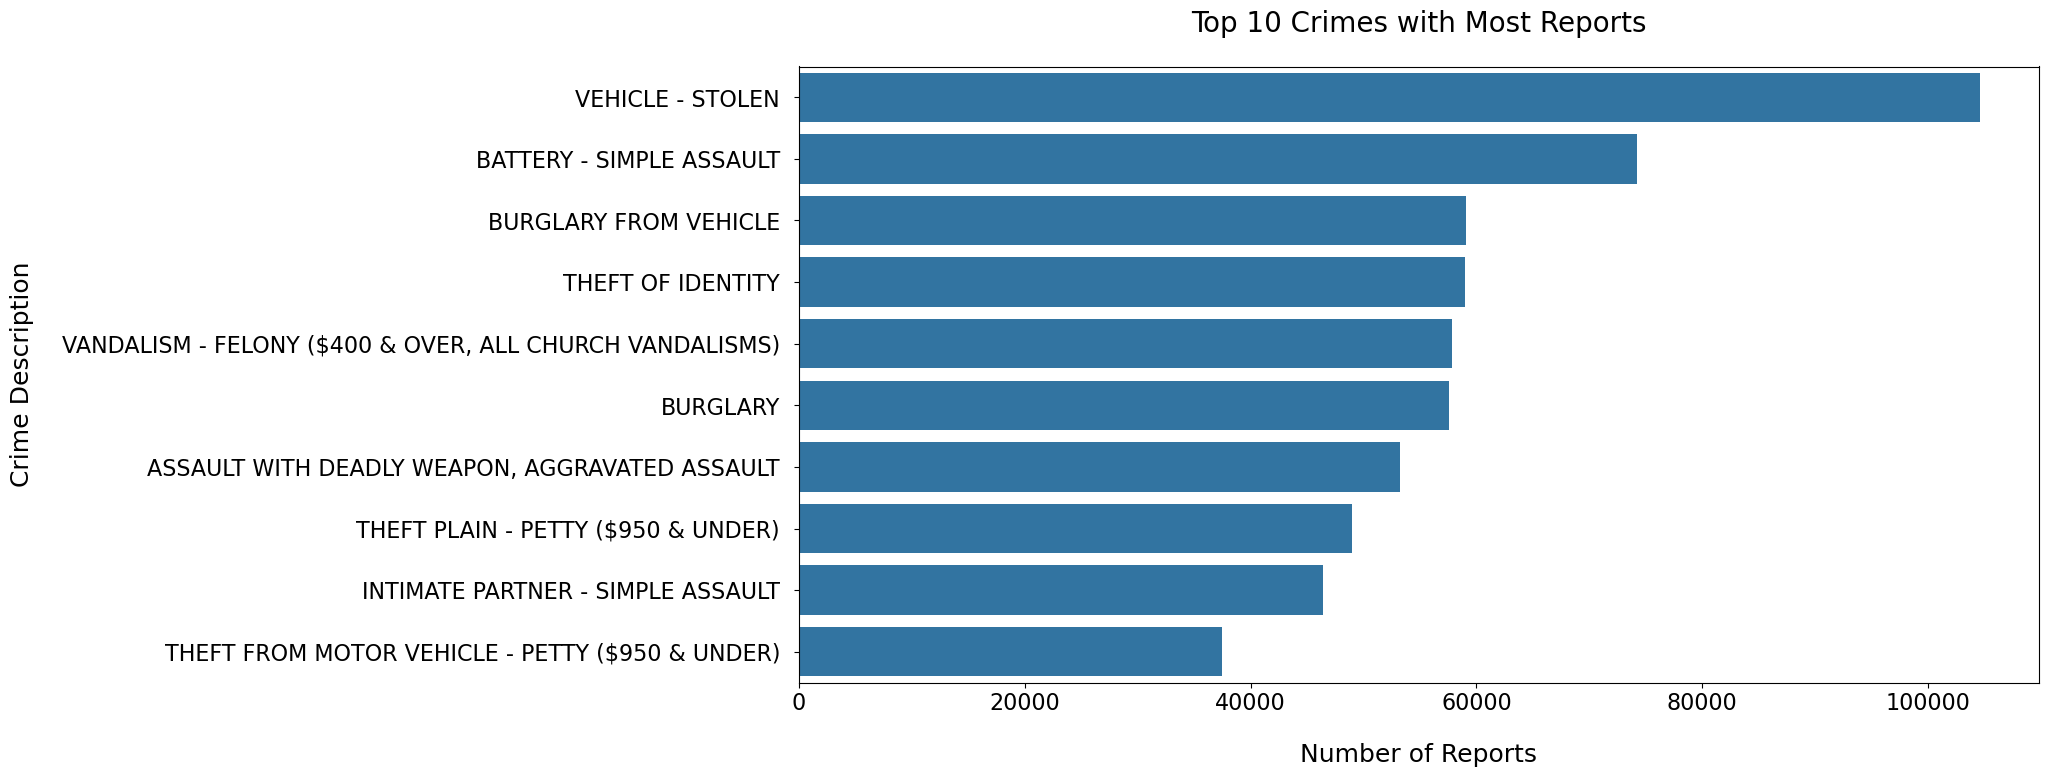

In [13]:
plt.figure(figsize=(16, 8))

sns.countplot(y='Crm Cd Desc', data=df, order=df['Crm Cd Desc'].value_counts().nlargest(10).index)

plt.title('Top 10 Crimes with Most Reports', fontsize=20, pad=25)
plt.xlabel('Number of Reports', fontsize=18, labelpad=20)
plt.ylabel('Crime Description', fontsize=18, labelpad=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.gca().tick_params(axis='y', pad=10)

plt.show()

In [14]:
bins = [0, 12, 18, 30, 50, 65, 100]  # Age ranges
labels = ['0-12 (Child)', '13-18 (Teen)', '19-30 (Young Adult)', '31-50 (Adult)', '51-65 (Middle Age)', '65+ (Senior)']

df['Vict Age'] = pd.to_numeric(df['Vict Age'], errors='coerce')

df['Age Group'] = pd.cut(df['Vict Age'], bins=bins, labels=labels, right=True)

age_group_counts = df['Age Group'].value_counts().sort_index()

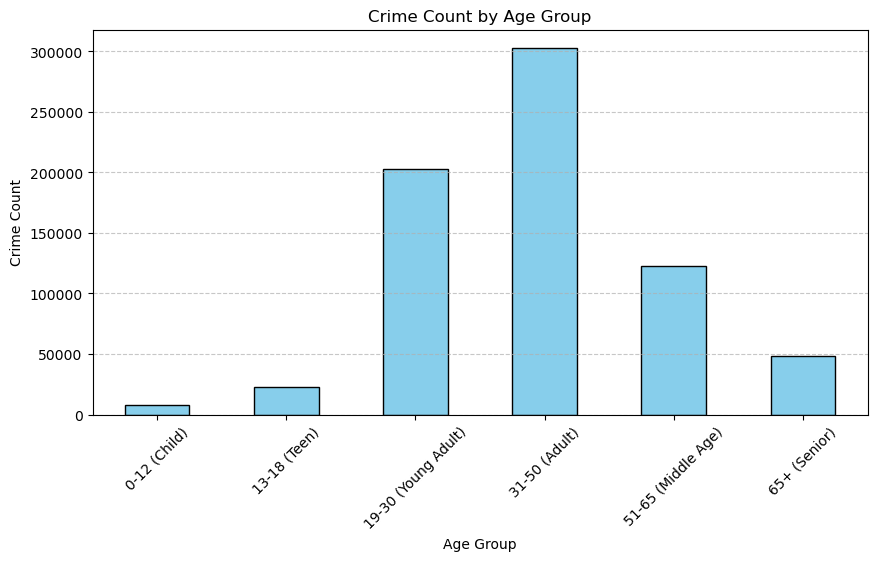

In [15]:
plt.figure(figsize=(10, 5))
age_group_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel("Age Group")
plt.ylabel("Crime Count")
plt.title("Crime Count by Age Group")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [16]:
df['Year-Month'] = df['DATE OCC'].dt.to_period('M')

In [17]:
# Filter data for the first six months of each year from 2020 to 2023
filtered_df = df[
    (df['DATE OCC'] >= pd.to_datetime('2020-01-01')) & 
    (df['DATE OCC'] <= pd.to_datetime('2023-06-30'))
]

In [18]:
crime_trend_adjusted = filtered_df.groupby('Year-Month').size()

crime_trend_adjusted.index = crime_trend_adjusted.index.to_timestamp()

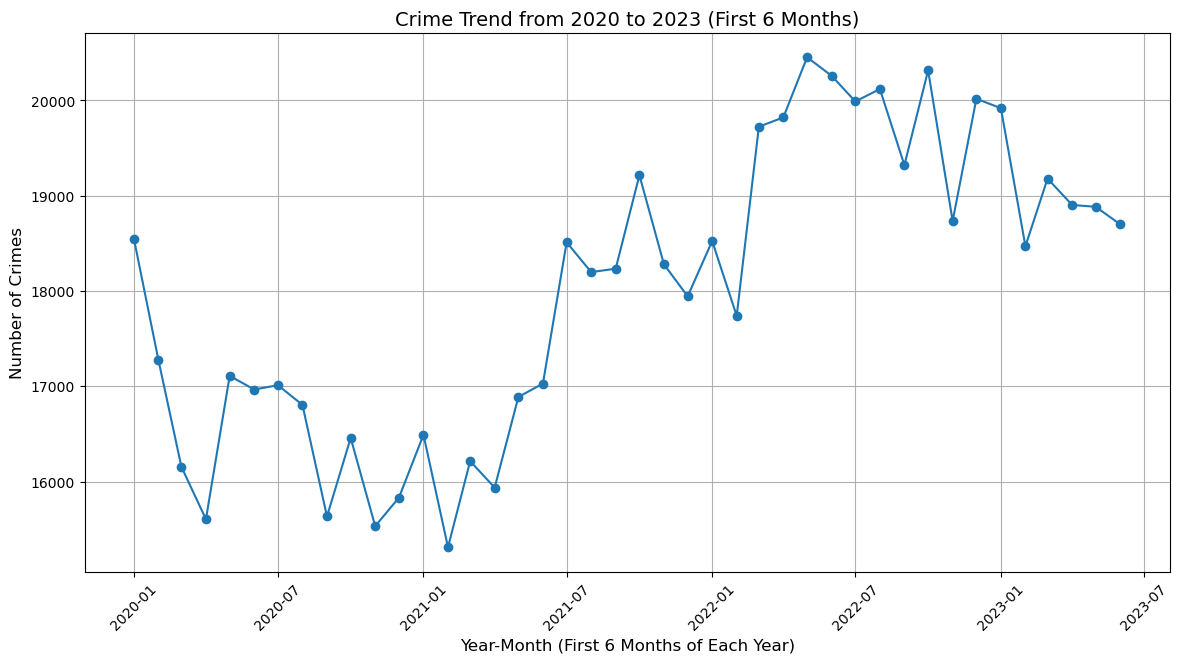

In [19]:
plt.figure(figsize=(14, 7))
plt.plot(crime_trend_adjusted.index, crime_trend_adjusted.values, marker='o', linestyle='-')

plt.title('Crime Trend from 2020 to 2023 (First 6 Months)', fontsize=14)
plt.xlabel('Year-Month (First 6 Months of Each Year)', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

In [20]:
df['Hour'] = df['TIME OCC'] // 100

hourly_crime_density = df['Hour'].value_counts().sort_index()

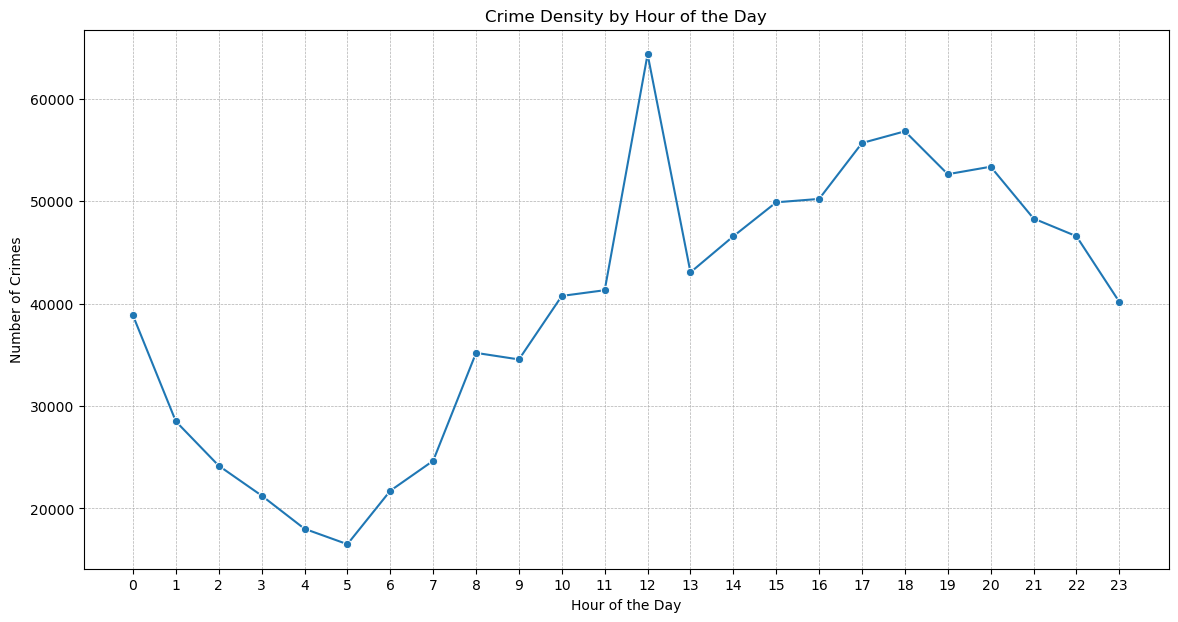

In [21]:
plt.figure(figsize=(14, 7))
sns.lineplot(x=hourly_crime_density.index, y=hourly_crime_density.values, marker='o')
plt.title('Crime Density by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 24))
plt.grid(axis='both', linestyle='--', linewidth=0.5)
plt.show()

In [22]:
df['Year'] = df['Date Rptd'].dt.year
df['Month'] = df['Date Rptd'].dt.month_name()

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

crime_month_year = df.groupby(['Month', 'Year']).size().unstack(fill_value=0).reindex(month_order)

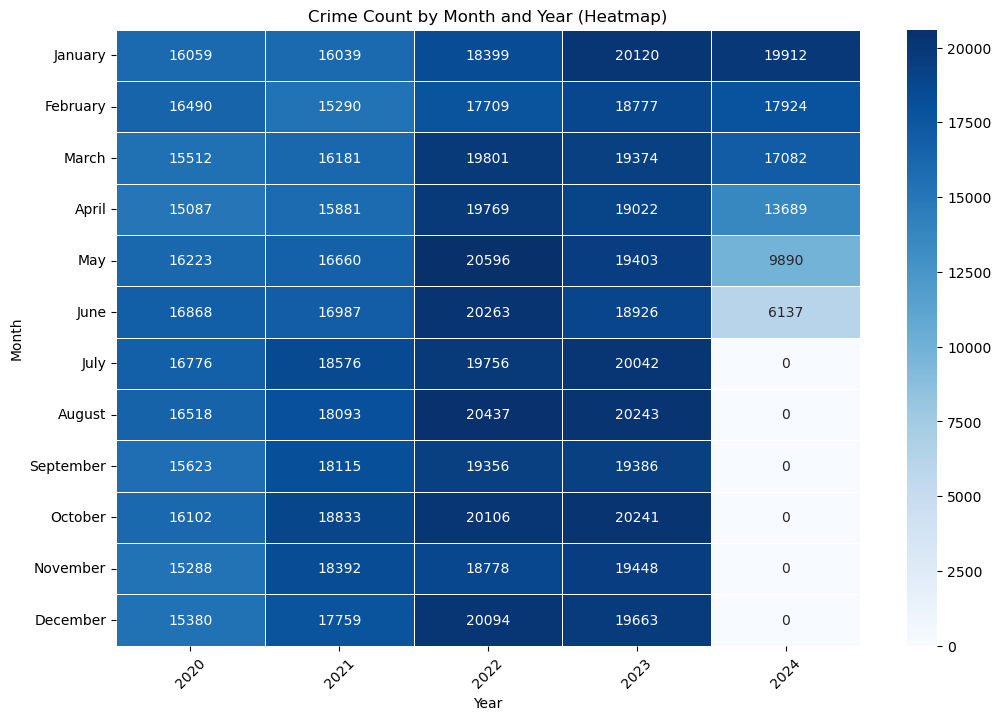

In [23]:
vmin_value = crime_month_year.min().min()  
vmax_value = crime_month_year.max().max()

cmap_choice = "Blues"

plt.figure(figsize=(12, 8))
ax = sns.heatmap(crime_month_year, annot=True, fmt='d', cmap=cmap_choice, linewidths=0.5, vmin=vmin_value, vmax=vmax_value)

plt.xticks(rotation=45)
plt.title('Crime Count by Month and Year (Heatmap)')
plt.xlabel('Year')
plt.ylabel('Month')

plt.show()

In [24]:
df_map=df.head(200000)

map_center = [df_map['LAT'].mean(), df_map['LON'].mean()]
crime_map = folium.Map(location=map_center, zoom_start=10)

marker_cluster = MarkerCluster().add_to(crime_map)

for _, row in df_map.iterrows():
    location = [row['LAT'], row['LON']]
    popup_text = f"Crime: {row['Crm Cd Desc']}<br>Location: {row['AREA NAME']}"
    folium.Marker(location=location, popup=popup_text).add_to(marker_cluster)

crime_map.save("crime_map.html")

## Clustering for the Year 2023 

In [26]:
filtered_2023_df = df[df['DATE OCC'].dt.year == 2023].copy()

In [27]:
X = filtered_2023_df[['LAT', 'LON']]

# Find Optimal k Using the Elbow Method
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

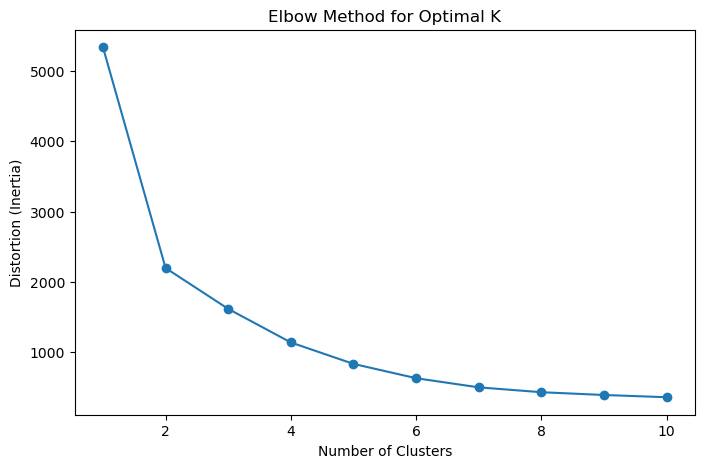

In [28]:
# Plot the Elbow Method Graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), distortions, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.show()


In [29]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

filtered_2023_df.loc[X.index, 'Cluster'] = kmeans.fit_predict(X)

In [30]:
filtered_2023_df['Hour'] = filtered_2023_df['TIME OCC'] // 100

# Assigning Colors
hour_bins = [0, 6, 12, 18, 24]
hour_labels = ['0-6', '7-12', '13-18', '19-24']
hour_colors = {
    '0-6': 'blue',
    '7-12': 'green',
    '13-18': 'yellow',
    '19-24': 'red'
}

In [31]:
filtered_2023_df['Hour Category'] = pd.cut(
    filtered_2023_df['Hour'],
    bins=hour_bins,
    labels=hour_labels,
    right=True,
    include_lowest=True
)

In [32]:
top_crime_types = [
    "VEHICLE - STOLEN",
    "BATTERY - SIMPLE ASSAULT",
    "BURGLARY FROM VEHICLE",
    "THEFT OF IDENTITY",
    "VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)"
]

filtered_df = filtered_2023_df[filtered_2023_df['Crm Cd Desc'].isin(top_crime_types)].copy()

In [33]:
# Create an empty dictionary to store crime groups
crime_groups = {}

for crime in top_crime_types:
    crime_groups[crime] = {}

    for time_period in hour_labels:
        # Create a FeatureGroup for this crime-time combination
        crime_groups[crime][time_period] = folium.FeatureGroup(
            name=f"{crime} - Time: {time_period}",
            show=False
        )

In [34]:
# Adding Crime Markers to the Map

for idx, row in filtered_df.iterrows():
    crime_type = row['Crm Cd Desc']
    time_period = row['Hour Category']

    # Ensure crime type and time period exist in the dictionary
    if crime_type in crime_groups and time_period in crime_groups[crime_type]:
        folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            radius=5,  
            color=hour_colors[time_period], 
            fill=True,
            fill_color=hour_colors[time_period],
            fill_opacity=0.7,
            popup=f"""
                <b>Crime:</b> {crime_type}<br>
                <b>Time:</b> {time_period}<br>
                <b>Location:</b> ({row['LAT']:.4f}, {row['LON']:.4f})
            """
        ).add_to(crime_groups[crime_type][time_period])

In [35]:
# Creating a Base Map
map_clusters = folium.Map(
    location=[filtered_df['LAT'].mean(), filtered_df['LON'].mean()],  # Centered on the dataset
    zoom_start=10
)

for crime, time_groups in crime_groups.items():
    for time_period, group in time_groups.items():
        group.add_to(map_clusters)

folium.LayerControl(collapsed=False).add_to(map_clusters)

map_clusters.save("crime_map_2023.html")

## Feature Engineering

In [37]:
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

df['Year'] = df['DATE OCC'].dt.year
df['Month'] = df['DATE OCC'].dt.month

df = df[['DATE OCC', 'AREA NAME', 'Year', 'Month']]

## Aggregate Crime Data by Area and Time

In [39]:
crime_monthly = df.groupby(['AREA NAME', 'Year', 'Month']).size().reset_index(name='Crime Count')

crime_monthly = crime_monthly.sort_values(by=['AREA NAME', 'Year', 'Month']).reset_index(drop=True)

## Preparing Training and Validation Data

In [41]:
train = crime_monthly[(crime_monthly['Year'] >= 2020) & (crime_monthly['Year'] < 2022)]
val = crime_monthly[(crime_monthly['Year'] == 2022)]

# Select features
X_train = train[['Year', 'Month']]
y_train = train['Crime Count']

X_val = val[['Year', 'Month']]
y_val = val['Crime Count']

In [42]:
# Convert AREA NAME to categorical and one-hot encode
X_train = pd.get_dummies(X_train.join(train['AREA NAME']))
X_val = pd.get_dummies(X_val.join(val['AREA NAME']))

## Train and Evaluate XGBoost Model

In [44]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

In [45]:
# Evaluate Model Performance
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 117.24715508355035
Root Mean Squared Error: 151.73359419779038


## Visualize and Evalulate Prediction Performance

In [47]:
# Ensure val is an independent DataFrame
val = val.copy()

val.loc[:, 'Predicted Crime Count'] = y_pred
area_comparison = val.groupby("AREA NAME")[['Crime Count', 'Predicted Crime Count']].sum()

# Calculate absolute error and percentage error
area_comparison['Absolute Error'] = abs(area_comparison['Crime Count'] - area_comparison['Predicted Crime Count'])
area_comparison['Percentage Error'] = (area_comparison['Absolute Error'] / area_comparison['Crime Count']) * 100
average_error = area_comparison['Percentage Error'].mean()

area_comparison = area_comparison.sort_values(by='Crime Count', ascending=False)

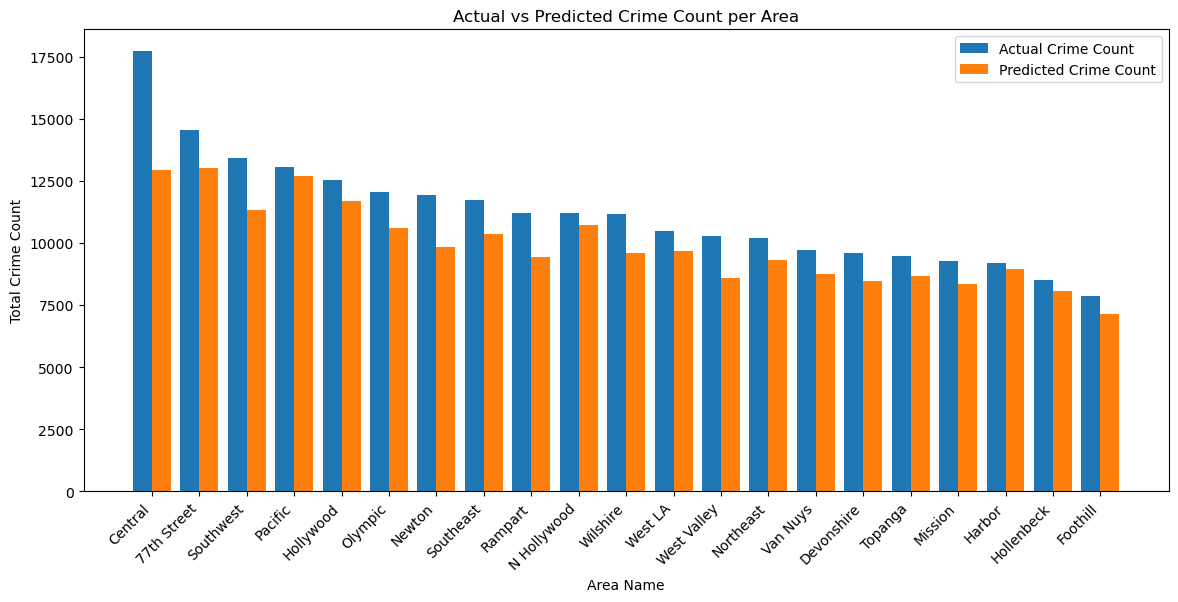

Average Percentage Error: 10.83%


In [48]:
plt.figure(figsize=(14, 6))
x = np.arange(len(area_comparison.index))

plt.bar(x - 0.2, area_comparison['Crime Count'], width=0.4, label="Actual Crime Count")
plt.bar(x + 0.2, area_comparison['Predicted Crime Count'], width=0.4, label="Predicted Crime Count")

plt.xlabel("Area Name")
plt.ylabel("Total Crime Count")
plt.title("Actual vs Predicted Crime Count per Area")
plt.xticks(ticks=x, labels=area_comparison.index, rotation=45, ha="right") 
plt.legend()
plt.show()

print(f"Average Percentage Error: {average_error:.2f}%")

## Future Crime Predictions for 2024

In [50]:
import pandas as pd

future_dates = pd.DataFrame({'Year': [2024] * 12, 'Month': list(range(1, 13))})

# One-hot encode AREA NAME for prediction
future_areas = pd.DataFrame({'AREA NAME': crime_monthly['AREA NAME'].unique()})
future_predictions = future_dates.merge(future_areas, how='cross')

In [51]:
X_future = pd.get_dummies(future_predictions)
X_future = X_future.reindex(columns=X_train.columns, fill_value=0)

future_predictions['Crime Count'] = model.predict(X_future)

In [52]:
future_predictions_2024 = future_predictions[future_predictions['Year'] == 2024]

month_names = {
    1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
    7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"
}

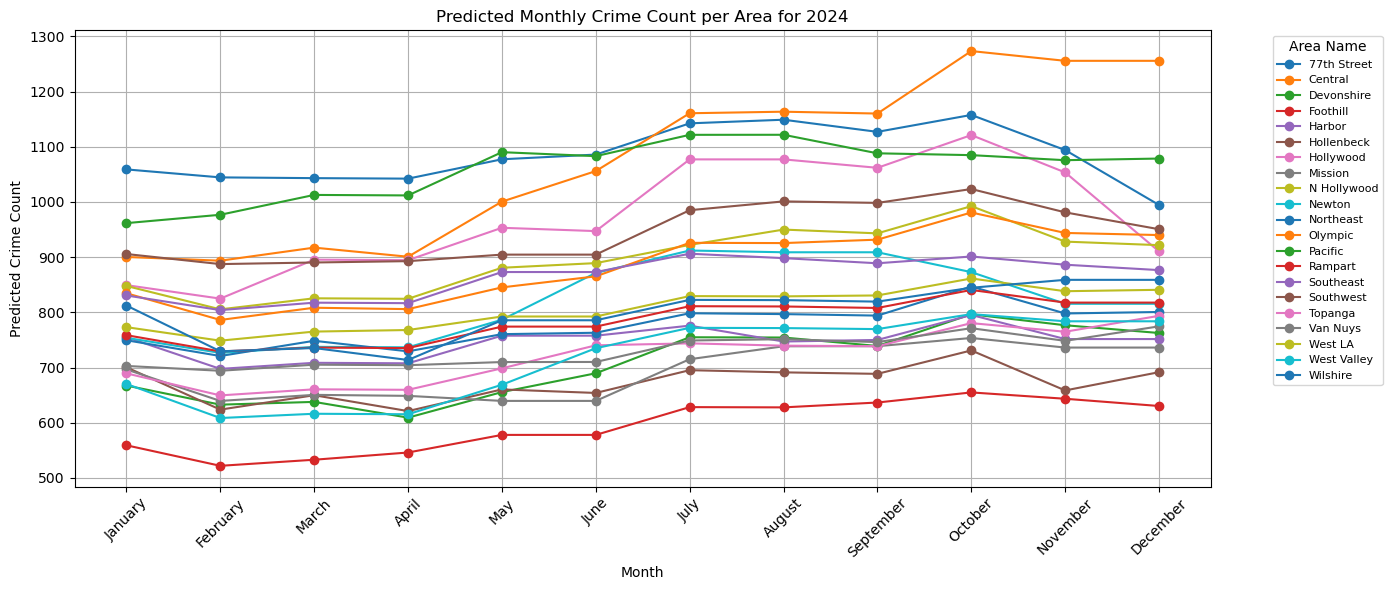

In [53]:
plt.figure(figsize=(14, 6))

for area in future_predictions_2024['AREA NAME'].unique():
    area_data = future_predictions_2024[future_predictions_2024['AREA NAME'] == area]
    plt.plot(area_data['Month'], area_data['Crime Count'], marker='o', label=area)

plt.xlabel("Month")
plt.ylabel("Predicted Crime Count")
plt.title("Predicted Monthly Crime Count per Area for 2024")

sorted_months = sorted(future_predictions_2024['Month'].unique())
plt.xticks(ticks=sorted_months, labels=[month_names[m] for m in sorted_months], rotation=45)

plt.legend(title="Area Name", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
future_predictions_2024['Month'] = future_predictions_2024['Month'].map(month_names)
future_predictions_2024['Crime Count'] = future_predictions_2024['Crime Count'].astype(int)

# Create a pivot table for a cleaner tabular format
table = future_predictions_2024.pivot(index='AREA NAME', columns='Month', values='Crime Count')

# Display the table
print("\nPredicted Crime Count per Area for 2024:")
print(table)


Predicted Crime Count per Area for 2024:
Month        April  August  December  February  January  July  June  March  \
AREA NAME                                                                    
77th Street   1042    1149       994      1044     1059  1142  1085   1043   
Central        900    1163      1255       893      900  1160  1056    917   
Devonshire     609     754       762       632      667   754   689    637   
Foothill       545     627       630       521      558   628   577    532   
Harbor         707     747       751       697      754   775   757    708   
Hollenbeck     621     691       691       623      700   695   653    649   
Hollywood      894    1077       910       824      849  1077   947    895   
Mission        648     738       736       639      696   715   639    650   
N Hollywood    824     949       921       805      847   922   889    825   
Newton         736     908       815       726      753   912   871    737   
Northeast      729    